In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from numpy.linalg import norm
from sklearn import preprocessing
import itertools
from sklearn.cluster import DBSCAN

In [2]:
df = pd.read_csv("E14.5_E1S3_Dorsal_Midbrain_GEM_CellBin_merge.tsv", sep="\t")
df.head()

,geneID,x,y,MIDCounts,cell
0,Arpc1b,19881,9379,3,170675
1,B230118H07Rik,19881,9379,2,170675
2,Bcl2l12,19881,9379,1,170675
3,Ccnd3,19881,9379,1,170675
4,Cdk8,19881,9379,3,170675


In [3]:
df.shape

(1656407, 5)

### Gene Expression Data - PCA

In [4]:
# First taking gene expression data (ignoring spatial data) to perform dimensionality reduction
gene_expressions = df[['geneID', 'MIDCounts', 'cell']].copy()
gene_expressions.head()

,geneID,MIDCounts,cell
0,Arpc1b,3,170675
1,B230118H07Rik,2,170675
2,Bcl2l12,1,170675
3,Ccnd3,1,170675
4,Cdk8,3,170675


In [5]:
gene_expressions.shape

(1656407, 3)

In [6]:
print('Unique genes:', len(gene_expressions.geneID.unique()))
print('Unique cells:', len(gene_expressions.cell.unique())   )  

Unique genes: 18698
Unique cells: 4872


In [7]:
# summing MIDCounts for each cell and gene
gene_expressions.groupby(['cell', 'geneID']).sum().to_csv("grouped.csv")
grouped = pd.read_csv("grouped.csv")
grouped.head().sort_values(by=['cell', 'geneID'])
grouped=grouped.set_index('geneID') 
grouped.head()

,cell,MIDCounts
geneID,,
Arpc1b,170675,3
B230118H07Rik,170675,2
Bcl2l12,170675,1
Ccnd3,170675,1
Cdk8,170675,3


In [8]:
# performing table pivoting in order to get data in a specific format such that genes become indeces and cells become columns
pvt = grouped.pivot(columns='cell').copy()
pvt.columns = pvt.columns.droplevel(0)

In [9]:
# checking dimensions
pvt.shape

(18698, 4872)

In [10]:
columns = pvt.columns # column names
pvt = pvt.fillna(0) # filling null values with zeros
scaled_data = pvt.T # transposing the matrix in order to perform PCA; skipping scaling because of PCA performance

In [11]:
pvt.tail(2)

cell,170675,170785,170808,170818,170819,170883,170916,170934,170943,170989,...,181834,181835,181837,181838,181839,181840,181841,181842,181843,181844
geneID,,,,,,,,,,,,,,,,,,,,,
mt-Nd5,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
mt-Nd6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,0.0,1.0,2.0,0.0,0.0,0.0


In [12]:
pca = PCA() # create a PCA object
pca.fit(scaled_data) # fit

PCA()

In [13]:
cells_scores = pca.transform(scaled_data) # get PCA coordinates for scaled_data

In [14]:
cells_scores.shape # checking dimensions

(4872, 4872)

In [15]:
100*pca.explained_variance_ratio_ # checking variance ratio

array([5.59328965e+01, 5.31018007e+00, 8.80237890e-01, ...,
       1.10308188e-29, 5.53043578e-32, 3.68596962e-32])

In [16]:
expl_var = pca.explained_variance_ratio_ 
per_var = np.round(expl_var* 100, decimals=1)
labels = ['PC' + str(x) for x in range(1, len(per_var)+1)] # getting PC labels

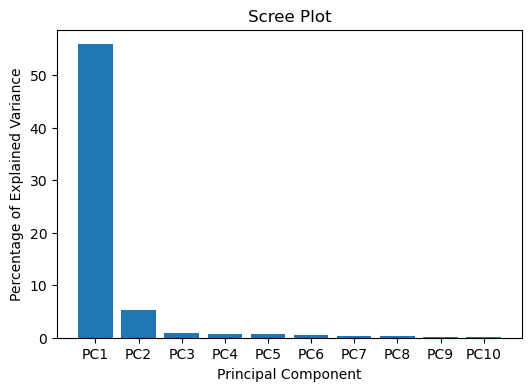

In [17]:
# constructing a Scree Plot to check the performance of PCA
# for the sake of our plot we will show only first 10
expl_var10 = pca.explained_variance_ratio_[:10]
per_var10 = np.round(expl_var10* 100, decimals=1)
labels10 = ['PC' + str(x) for x in range(1, len(per_var10)+1)]

plt.figure(figsize=(6,4))
plt.bar(x=range(1,len(per_var10)+1), height=per_var10, tick_label=labels10)
plt.ylabel('Percentage of Explained Variance')
plt.xlabel('Principal Component')
plt.title('Scree Plot')
plt.show()

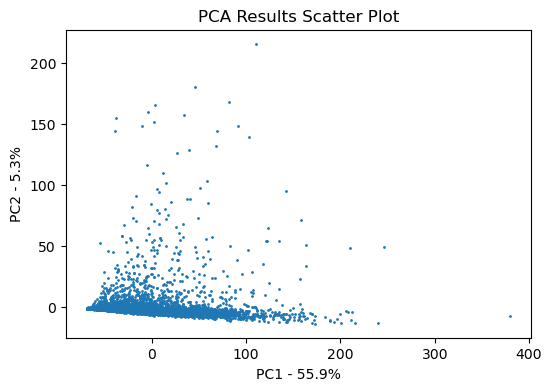

In [18]:
# plotting the results of PCA 
pca_df = pd.DataFrame(cells_scores, index=columns, columns=labels)
 
plt.figure(figsize=(6,4))
plt.scatter(pca_df.PC1, pca_df.PC2, s=1)
plt.title('PCA Results Scatter Plot')
plt.xlabel('PC1 - {0}%'.format(per_var[0]))
plt.ylabel('PC2 - {0}%'.format(per_var[1]))
  
plt.show()

## Spatial Data

In [19]:
# Now we're taking only spatial data for each cell
spatial = df[['cell', 'x', 'y']].set_index('cell').copy()
spatial.head()

,x,y
cell,,
170675,19881,9379
170675,19881,9379
170675,19881,9379
170675,19881,9379
170675,19881,9379


In [20]:
# Since each cell can have a few x and y coordinates, we are taking their averages to get unique coordinates for every cell
spatial['x_avg'] = spatial.groupby('cell').x.mean()
spatial['y_avg'] = spatial.groupby('cell').y.mean()

In [21]:
# removing old coordinates and deleting dulicates
spatial.drop(columns=['x', 'y'], inplace=True)
spatial = spatial.drop_duplicates()
spatial.shape

(4872, 2)

Text(0, 0.5, 'y avg')

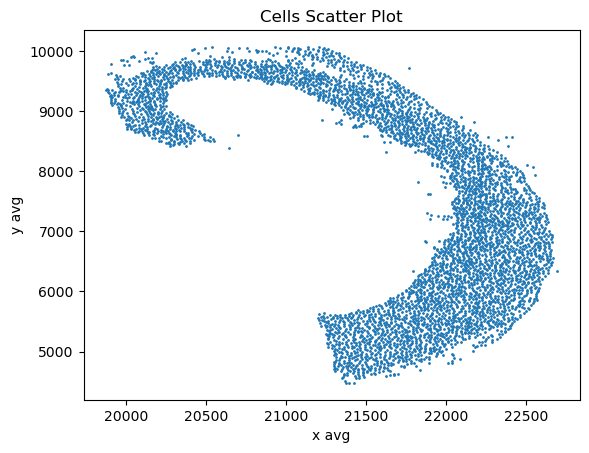

In [22]:
# plotting the spatial data
plt.scatter(spatial.x_avg, spatial.y_avg, s=1)
plt.title('Cells Scatter Plot')
plt.xlabel('x avg')
plt.ylabel('y avg')

In [23]:
# performing min-max normalization to get the data in the range (0,1)
spatial['x_avg'] = (spatial['x_avg'] - spatial['x_avg'].min())/(spatial['x_avg'].max()-spatial['x_avg'].min())
spatial['y_avg'] = (spatial['y_avg'] - spatial['y_avg'].min())/(spatial['y_avg'].max()-spatial['y_avg'].min())

Text(0, 0.5, 'y avg')

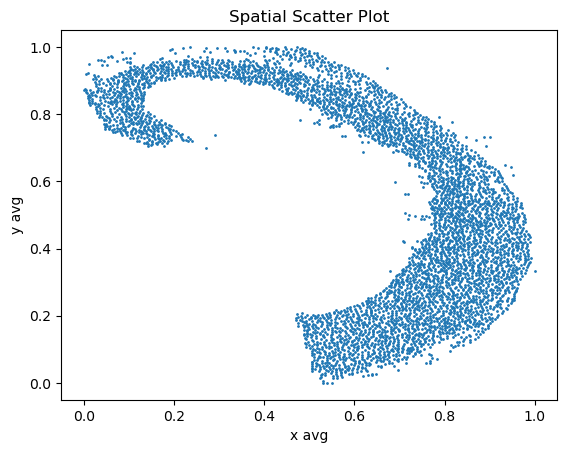

In [24]:
# plotting normalized spatial data
plt.scatter(spatial.x_avg, spatial.y_avg, s=1)
plt.title('Spatial Scatter Plot')
plt.xlabel('x avg')
plt.ylabel('y avg')

In [25]:
pca_data = pca_df[['PC1', 'PC2']].copy() 
#pca_data.head()

Text(0, 0.5, 'PC2')

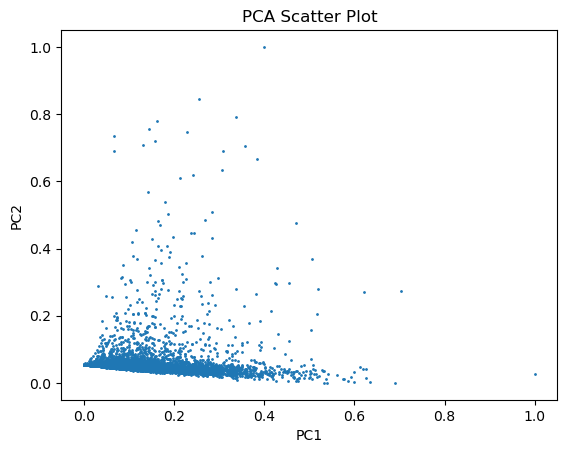

In [26]:
# normalizing PCA data as well 
pca_data.loc[:,'PC1'] = (pca_data.loc[:,'PC1'] - pca_data.loc[:,'PC1'].min())/(pca_data.loc[:,'PC1'].max()-pca_data.loc[:,'PC1'].min())
pca_data.loc[:,'PC2'] = (pca_data.loc[:,'PC2'] - pca_data.loc[:,'PC2'].min())/(pca_data.loc[:,'PC2'].max()-pca_data.loc[:,'PC2'].min())
plt.scatter(pca_data.PC1, pca_data.PC2, s=1)
plt.title('PCA Scatter Plot')
plt.xlabel('PC1')
plt.ylabel('PC2')

### Defining distance functions

In [27]:
# Euclidean distance
def euclidian_distance(x_1, x_2, y_1, y_2):
    return np.sqrt((x_1-x_2)**2+(y_1-y_2)**2)

In [28]:
# weighted sum
def weighted_sum(a, b, weight=0.5):
    return a*weight + b*(1-weight)

In [29]:
# Cartesian product to get all pairs of cells for their distance calculation
pairs = list(itertools.product(spatial.index, repeat=2))
distances = pd.DataFrame(pairs, columns=['cell1', 'cell2'])

In [30]:
# getting spatial coordinates for each pair of cells
distances = pd.merge(distances, spatial[['x_avg', 'y_avg']], left_on='cell1', right_on=spatial.index, how='left')
distances.rename(columns = {'x_avg':'x_avg_1', 'y_avg':'y_avg_1'}, inplace = True)
distances = pd.merge(distances, spatial[['x_avg', 'y_avg']], left_on='cell2', right_on=spatial.index, how='left')
distances.rename(columns = {'x_avg':'x_avg_2', 'y_avg':'y_avg_2'}, inplace = True)

In [31]:
# calculating Euclidean distance for spatial data
distances['euclidean_spatial'] = euclidian_distance(distances.x_avg_1,distances.x_avg_2,distances.y_avg_1,distances.y_avg_2)


In [32]:
distances.head(2)

,cell1,cell2,x_avg_1,y_avg_1,x_avg_2,y_avg_2,euclidean_spatial
0,170675,170675,0.002128,0.875826,0.002128,0.875826,0.000000
1,170675,170785,0.002128,0.875826,0.000000,0.870645,0.005601


In [33]:
# getting gene expression projection (PCA) coordinates for each pair of cells
distances = pd.merge(distances, pca_data[['PC1', 'PC2']], left_on='cell1', right_on=pca_data.index, how='left')
distances.rename(columns = {'PC1':'PC1_1', 'PC2':'PC2_1'}, inplace = True)
distances = pd.merge(distances, pca_data[['PC1', 'PC2']], left_on='cell2', right_on=pca_data.index, how='left')
distances.rename(columns = {'PC1':'PC1_2', 'PC2':'PC2_2'}, inplace = True)

In [34]:
# calculating Euclidean distance for pca data
distances['euclidean_pca'] = euclidian_distance(distances.PC1_1,distances.PC1_2,distances.PC2_1,distances.PC2_2)

In [35]:
distances.head(2)

,cell1,cell2,x_avg_1,y_avg_1,x_avg_2,y_avg_2,euclidean_spatial,PC1_1,PC2_1,PC1_2,PC2_2,euclidean_pca
0,170675,170675,0.002128,0.875826,0.002128,0.875826,0.000000,0.056452,0.051347,0.056452,0.051347,0.000000
1,170675,170785,0.002128,0.875826,0.000000,0.870645,0.005601,0.056452,0.051347,0.000182,0.053295,0.056303


In [36]:
# calculating weighted total distances for some different weights; 
# from this calculations we can easily create distance matrices for each weight by doing pivoting
for weight in [0, 0.25, 0.5, 0.75, 1]:
    col_name = 'weighted_dist' + str(weight).replace('.','')
    distances[col_name] = weighted_sum(distances['euclidean_spatial'], distances['euclidean_pca'], weight)

In [37]:
distances.head(2)

,cell1,cell2,x_avg_1,y_avg_1,x_avg_2,y_avg_2,euclidean_spatial,PC1_1,PC2_1,PC1_2,PC2_2,euclidean_pca,weighted_dist0,weighted_dist025,weighted_dist05,weighted_dist075,weighted_dist1
0,170675,170675,0.002128,0.875826,0.002128,0.875826,0.000000,0.056452,0.051347,0.056452,0.051347,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,170675,170785,0.002128,0.875826,0.000000,0.870645,0.005601,0.056452,0.051347,0.000182,0.053295,0.056303,0.056303,0.043627,0.030952,0.018277,0.005601


In [38]:
# checking some basic statistics of the new columns
stats = distances[['euclidean_spatial', 'euclidean_pca', 'weighted_dist0', 'weighted_dist025', 'weighted_dist05', 'weighted_dist075', 'weighted_dist1']].describe().transpose()
stats.head(7)

,count,mean,std,min,25%,50%,75%,max
euclidean_spatial,23736384.0,0.469730,0.277965,0.0,0.224167,0.442395,0.706205,1.185613
euclidean_pca,23736384.0,0.121300,0.108559,0.0,0.045169,0.091803,0.164376,1.171534
weighted_dist0,23736384.0,0.121300,0.108559,0.0,0.045169,0.091803,0.164376,1.171534
weighted_dist025,23736384.0,0.208407,0.107758,0.0,0.128619,0.198457,0.269935,1.106779
weighted_dist05,23736384.0,0.295515,0.149891,0.0,0.170242,0.283152,0.414709,1.042024
weighted_dist075,23736384.0,0.382622,0.210598,0.0,0.198635,0.362441,0.560549,1.011078
weighted_dist1,23736384.0,0.469730,0.277965,0.0,0.224167,0.442395,0.706205,1.185613


In [39]:
# function that does table pivoting for distance matrix calculation
def pivoting(threshold, distances_table):
    # creating pivoted table
    col_name = 'weighted_dist' + str(threshold).replace('.','')
    pivoted = distances_table[['cell1', 'cell2', col_name]].set_index('cell1').pivot(columns='cell2')
    pivoted.columns = pivoted.columns.droplevel(0)
    return pivoted

In [40]:
# DBSCAN clustering using precomputed distance matrix
def DBSCAN_clustering(pivoted, eps=0.05, min_samples=2):
    clustering = DBSCAN(eps=eps, min_samples=min_samples, metric='precomputed')
    clustering.fit(pivoted)
    pred = clustering.fit_predict(pivoted)
    return pred

In [41]:
# function for plotting the clustered data
def plotting(pred, spatial):
    plt.figure(figsize=(7,4))
    scatter = plt.scatter(spatial.to_numpy()[:,0], spatial.to_numpy()[:,1],c=pred, cmap='Paired', s=3)
#     legend1 = plt.legend(*scatter.legend_elements(),
#                     loc="lower left", title="groups")
#    plt.title("Clusters determined by DBSCAN")

In [42]:
# function to perform nearest neighbors clustering using precomputed distance matrix
def nearest_neighbors_clustering(distance_matrix, max_distance):
    num_points = len(distance_matrix)
    cluster_labels = [0] * num_points
  
    # initializing the list of clusters
    clusters = []
    clusters_df = pd.DataFrame(0, index=np.arange(num_points) ,columns=['cluster'])
  
    # iterate over all points and assign them to clusters
    for i in range(num_points):
        # if the point has not been assigned to a cluster
        if cluster_labels[i] == 0:
            # create a new cluster with this point
            cluster = [i]
            cluster_labels[i] = len(clusters) + 1
            clusters.append(cluster)
            clusters_df.iloc[i,0] = cluster_labels[i]

            # iterate over the remaining points and assign them to the cluster if they are within the maximum allowed distance
            for j in range(i+1, num_points):
                if cluster_labels[j] == 0 and distance_matrix[i, j] <= max_distance:
                    cluster.append(j)
                    cluster_labels[j] = cluster_labels[i]
                    clusters_df.iloc[j,0] = cluster_labels[i]

    return clusters_df

In [43]:
def clustering(distances, weight=0.5, percentage_distance_thr=0.05, random=False):
    # checking if weight is one of the predefined ones
    if weight not in [0, 0.25, 0.5, 0.75, 1]:
        print("The weight must be one of these values: 0, 0.25, 0.5, 0.75, 1")
        return
    
    # compute the distance matrix
    dst_matrix = pivoting(weight, distances)
    # sfuffling the data in pivoted table
    if random:
        dst_matrix = dst_matrix.sample(frac=1)
    distance_matrix = dst_matrix.to_numpy()

    # compute max distance for the chosen wight
    col_name = 'weighted_dist' + str(weight).replace('.','')
    max_dist = distances[col_name].max()

    clusters_df = nearest_neighbors_clustering(distance_matrix, max_dist*percentage_distance_thr)

    print('The number of obtained clusters: ', clusters_df.cluster.nunique())
    
    plotting(clusters_df.cluster.to_numpy(), spatial)

## Results 

### Nearest Neighbors

The number of obtained clusters:  23


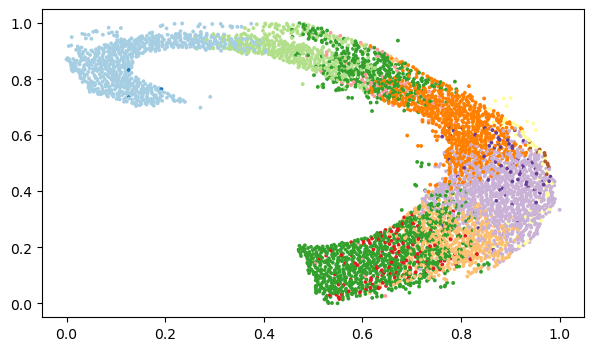

In [44]:
# call the function with chosen parameters for weight and percentage distance threshold
clustering(distances, weight=0.5, percentage_distance_thr=0.2)

The number of obtained clusters:  66


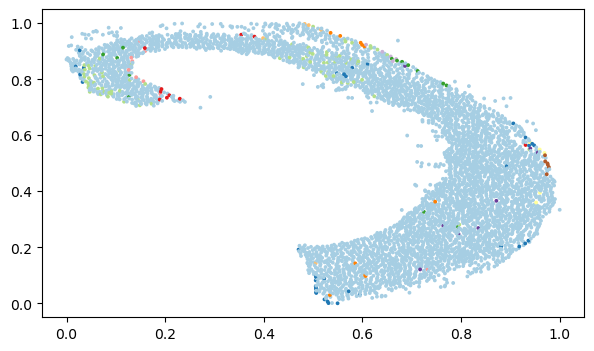

In [45]:
# call the function with chosen parameters for weight and percentage distance threshold
clustering(distances, weight=0.5, percentage_distance_thr=0.2, random =True)

The number of obtained clusters:  38


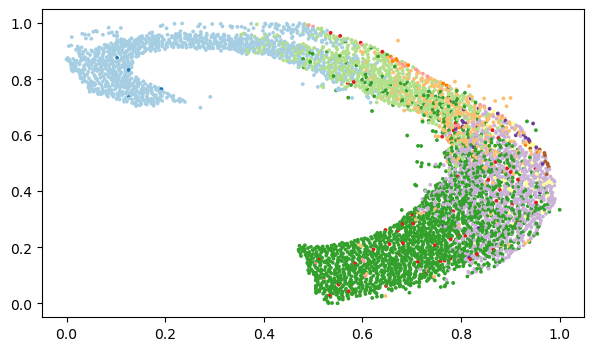

In [46]:
# call the function with chosen parameters for weight and percentage distance threshold
clustering(distances,0.25, 0.15)

### DBSCAN 

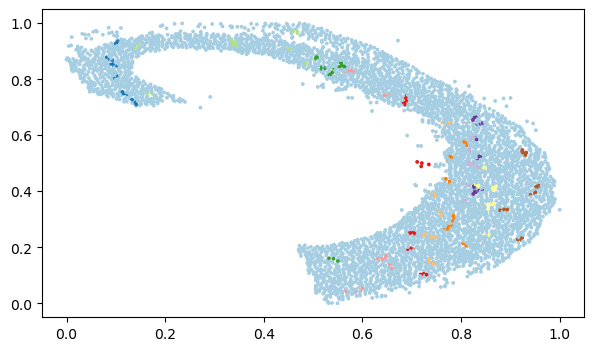

In [47]:
# weight 0.5
pred = DBSCAN_clustering(pivoting(0.5, distances), 0.008, 3)
plotting(pred, spatial)

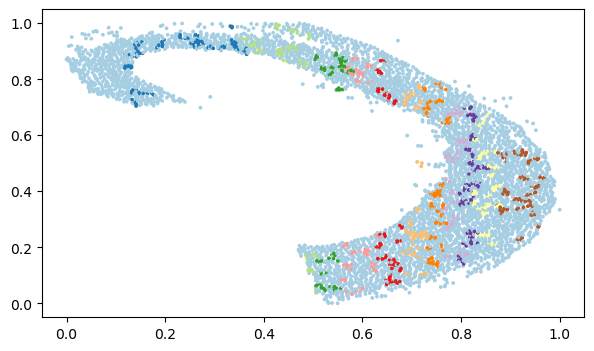

In [48]:
# weight 0.75
pred = DBSCAN_clustering(pivoting(0.75, distances), 0.01, 3)
plotting(pred, spatial)

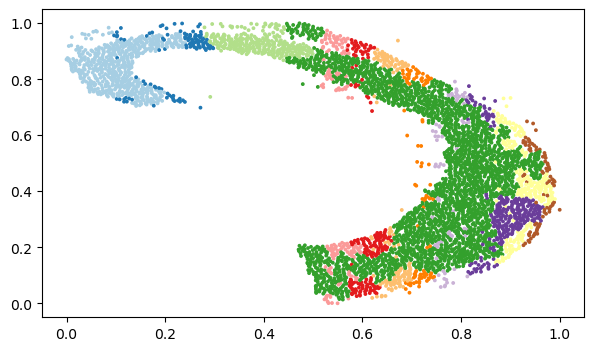

In [49]:
# weight 1; only gene expression distace is considered
pred = DBSCAN_clustering(pivoting(1, distances), 0.008, 1)
plotting(pred, spatial)

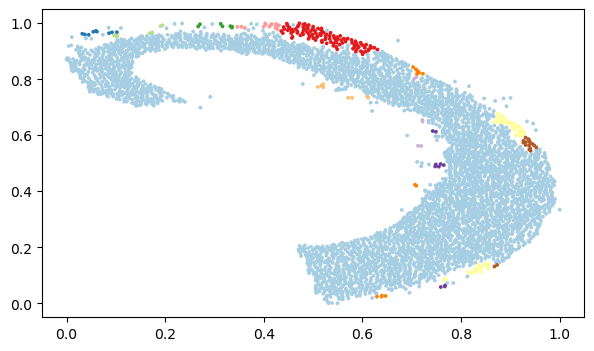

In [50]:
pred = DBSCAN_clustering(pivoting(1, distances), 0.01, 2)
plotting(pred, spatial)

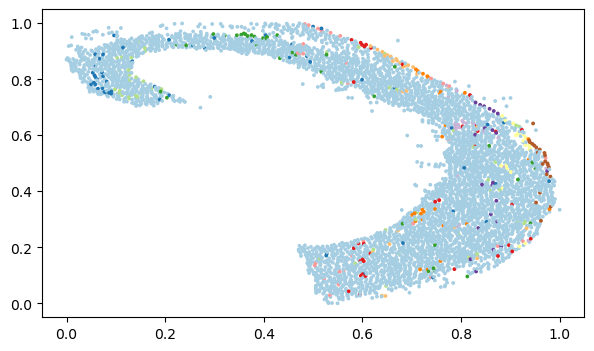

In [51]:
# weight 0; only gene expression distace is considered
pred = DBSCAN_clustering(pivoting(0, distances), 0.008, 1)
plotting(pred, spatial)

In [52]:
stats.head(7)

,count,mean,std,min,25%,50%,75%,max
euclidean_spatial,23736384.0,0.469730,0.277965,0.0,0.224167,0.442395,0.706205,1.185613
euclidean_pca,23736384.0,0.121300,0.108559,0.0,0.045169,0.091803,0.164376,1.171534
weighted_dist0,23736384.0,0.121300,0.108559,0.0,0.045169,0.091803,0.164376,1.171534
weighted_dist025,23736384.0,0.208407,0.107758,0.0,0.128619,0.198457,0.269935,1.106779
weighted_dist05,23736384.0,0.295515,0.149891,0.0,0.170242,0.283152,0.414709,1.042024
weighted_dist075,23736384.0,0.382622,0.210598,0.0,0.198635,0.362441,0.560549,1.011078
weighted_dist1,23736384.0,0.469730,0.277965,0.0,0.224167,0.442395,0.706205,1.185613
